# Generative adversarial networks

1. Discriminator  
실제 데이터를 1에 가깝게  

2. Generator  
생성자의 출력 값이 0에 가까울수록

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 26421880/26421880 [00:02<00:00, 11988766.16it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204857.34it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3802152.25it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20085839.06it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2),
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./fmnist_disc.pth'))
    generator.load_state_dict(torch.load('./fmnist_gner.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

In [9]:
discriminator.load_state_dict(torch.load('./fmnist_disc.pth'))

<All keys matched successfully>

In [10]:
generator.load_state_dict(torch.load('./fmnist_gner.pth'))

<All keys matched successfully>

In [6]:
def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n)) ###

    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()

    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))

    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
test_noise = noise(64)
l = len(trainloader)

for epoch in range(51):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        ## discriminator
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        ## generator
        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))


Epoch 0: g_loss: 1.017 d_loss: 1.220
Epoch 10: g_loss: 0.994 d_loss: 1.225
Epoch 20: g_loss: 1.012 d_loss: 1.213
Epoch 30: g_loss: 0.990 d_loss: 1.232
Epoch 40: g_loss: 1.001 d_loss: 1.223
Epoch 50: g_loss: 0.960 d_loss: 1.238


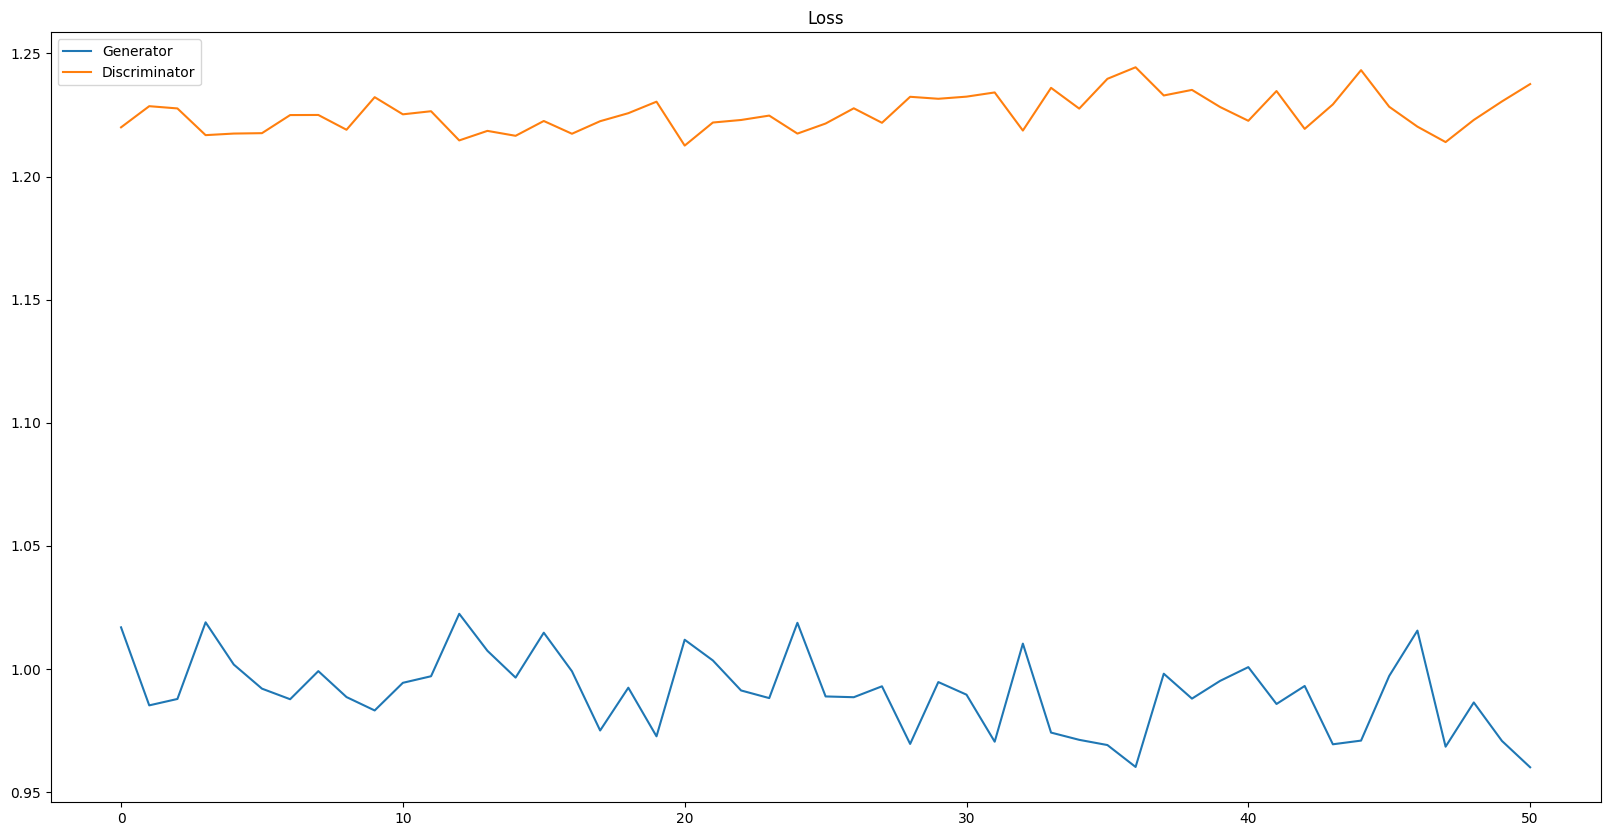

In [13]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

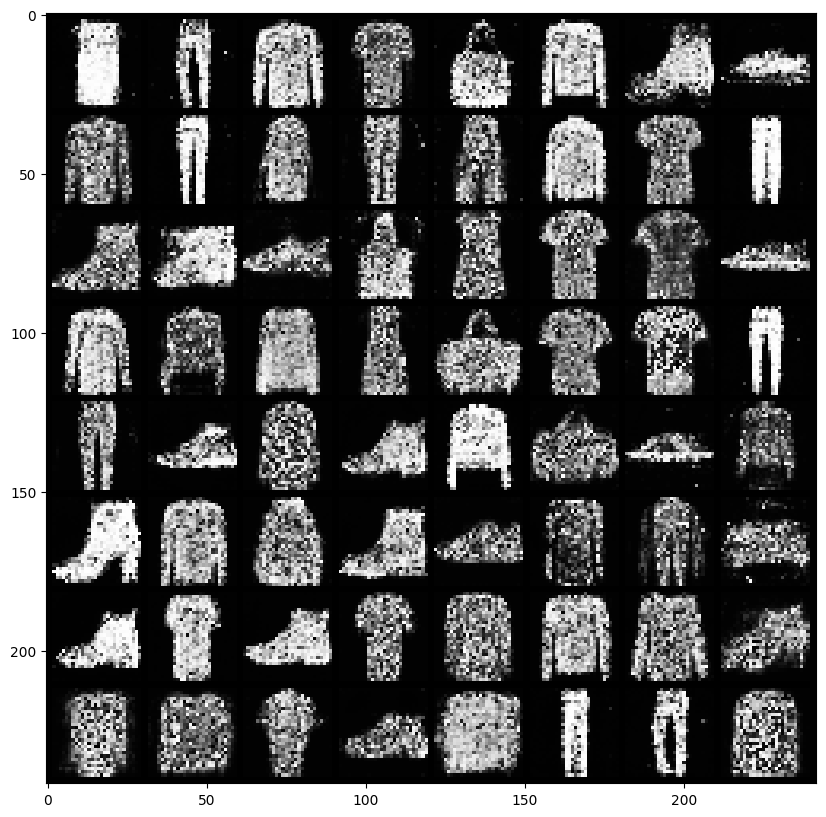

In [14]:
test_noise = noise(64)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [15]:
# pip install torchinfo

In [16]:
from torchinfo import summary

In [17]:
summary(discriminator)

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       803,840
│    └─LeakyReLU: 2-2                    --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       524,800
│    └─LeakyReLU: 2-5                    --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       131,328
│    └─LeakyReLU: 2-8                    --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      257
│    └─Sigmoid: 2-11                     --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0

In [26]:
summary(model = discriminator, input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1024]                 803,840
│    └─LeakyReLU: 2-2                    [1, 1024]                 --
│    └─Dropout: 2-3                      [1, 1024]                 --
│    └─Linear: 2-4                       [1, 512]                  524,800
│    └─LeakyReLU: 2-5                    [1, 512]                  --
│    └─Dropout: 2-6                      [1, 512]                  --
│    └─Linear: 2-7                       [1, 256]                  131,328
│    └─LeakyReLU: 2-8                    [1, 256]                  --
│    └─Dropout: 2-9                      [1, 256]                  --
│    └─Linear: 2-10                      [1, 1]                    257
│    └─Sigmoid: 2-11                     [1, 1]                    --

In [18]:
summary(generator)

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
│    └─Linear: 2-7                       803,600
│    └─Tanh: 2-8                         --
Total params: 1,493,520
Trainable params: 1,493,520
Non-trainable params: 0

In [35]:
summary(model=generator, input_size=(128,))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Sequential: 1-1                        [784]                     --
│    └─Linear: 2-1                       [256]                     33,024
│    └─LeakyReLU: 2-2                    [256]                     --
│    └─Linear: 2-3                       [512]                     131,584
│    └─LeakyReLU: 2-4                    [512]                     --
│    └─Linear: 2-5                       [1024]                    525,312
│    └─LeakyReLU: 2-6                    [1024]                    --
│    └─Linear: 2-7                       [784]                     803,600
│    └─Tanh: 2-8                         [784]                     --
Total params: 1,493,520
Trainable params: 1,493,520
Non-trainable params: 0
Total mult-adds (G): 1.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.97
Estimated Total Size 

In [19]:
temp = next(iter(trainloader))

In [20]:
len(temp)

2

In [21]:
temp[0].shape

torch.Size([100, 1, 28, 28])

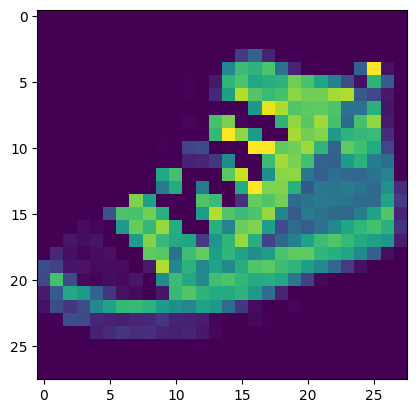

In [22]:
plt.imshow(temp[0][0,0,:,:])

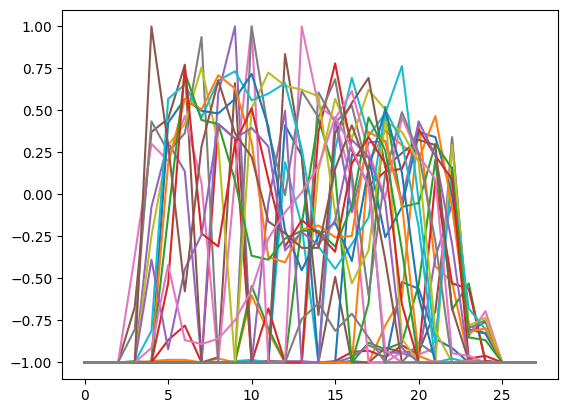

In [24]:
plt.plot(temp[0][0,0,:,:]);

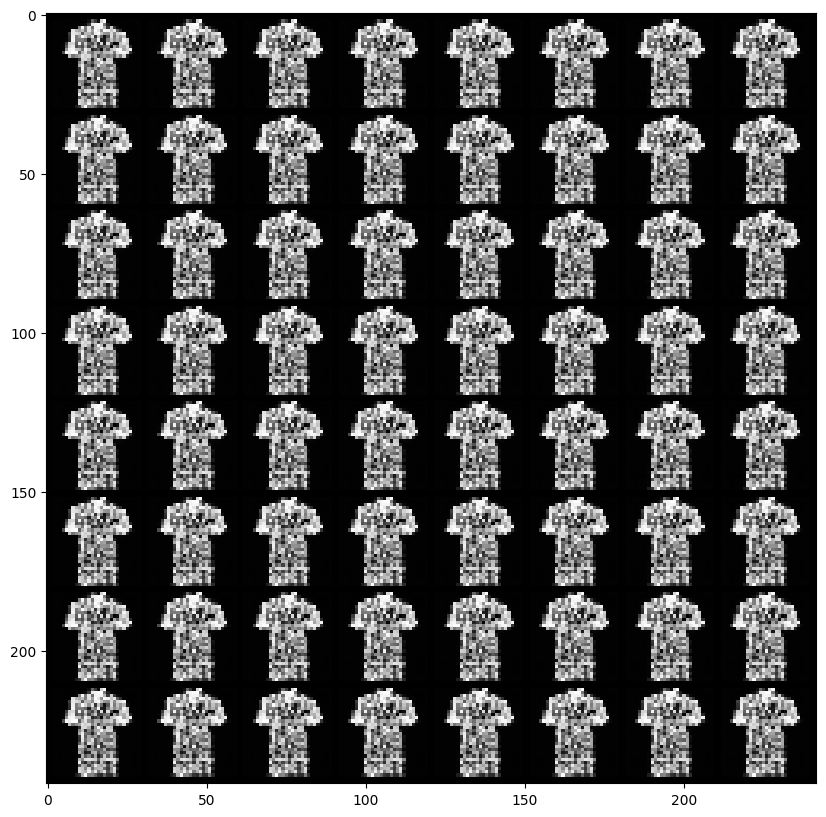

In [37]:
test_noise = torch.ones(64, 128).to(device)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

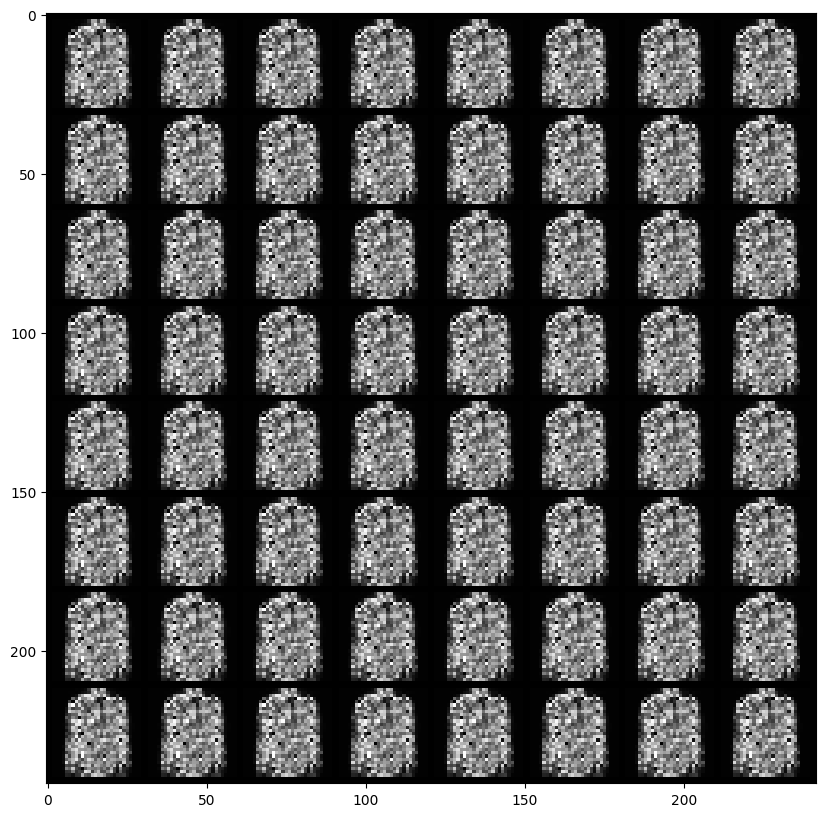

In [38]:
test_noise = torch.zeros(64, 128).to(device)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

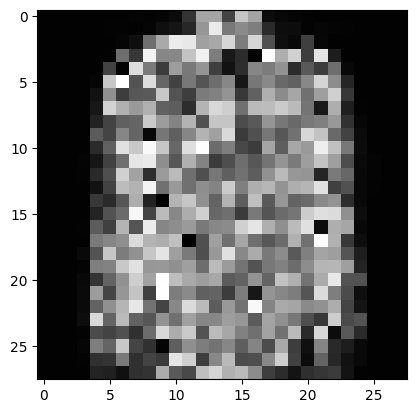

In [41]:
test_noise = torch.zeros(1, 128).to(device)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
# plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

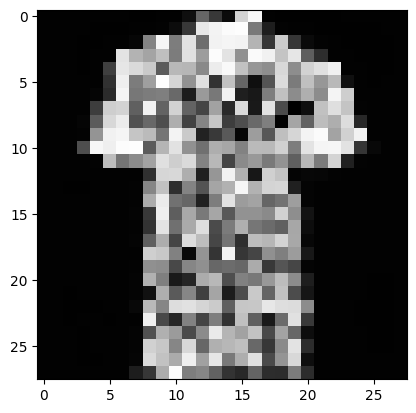

In [42]:
test_noise = torch.ones(1, 128).to(device)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
# plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()